# Transfer Learning

In [2]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Tuple
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms


In [3]:
# 난수 시드 설정
torch.manual_seed(1024)
np.random.seed(1024)
random.seed(1024)


## DataSet 작성

In [4]:
class ImageTransform():
    def __init__(
        self,
        resize: int=224,
        mean: Tuple[float, float, float]=(0.485, 0.456, 0.406),
        std: Tuple[float, float, float]=(0.229, 0.224, 0.225)
    ) -> None:
        self._transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)
                ),  # 원본 영상의 0.5 ~ 1 사이의 크기로 영상을 잘라내서 resize 로 변환
                transforms.RandomHorizontalFlip(),  # 임의 비율로 이미지의 상하 반전
                transforms.ToTensor(),  # PIL image를 Tensor로 변환
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize), # 이미 영상을 resize로 크기 조정했는데, center crop하는게 의미 있을까?
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase='train'):
        """
        preprocess image and return result.
        
        :param img: image for preprocess
        :param phase: phase of model development process(train, val)
        """
        return self._transform[phase](img)


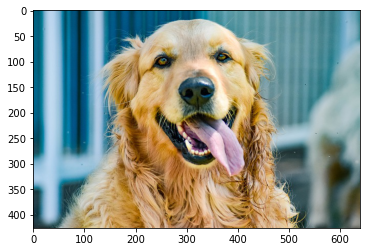

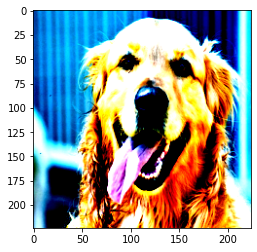

In [5]:
image_file = ".\data\goldenretriever-3724972_640.jpg"
img = Image.open(image_file) # (높이, 넓이, 색상)

plt.imshow(img)
plt.show()

resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(resize, mean, std)
img_transformed = transform(img, phase="train")

img_show = img_transformed.numpy().transpose((1, 2, 0)) # (색상, 높이, 넓이) --> (높이, 넓이, 색상)
img_show = np.clip(img_show, 0, 1)
plt.imshow(img_show)
plt.show()

In [6]:
def make_datapath_list(phase="train"):
    root_path = osp.join(".","data","hymenoptera_data")
    target_path = osp.join(root_path,phase,"**","*.jpg")
    print(target_path)

    path_list = []

    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

In [7]:
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

print(train_list)

.\data\hymenoptera_data\train\**\*.jpg
.\data\hymenoptera_data\val\**\*.jpg
['.\\data\\hymenoptera_data\\train\\ants\\0013035.jpg', '.\\data\\hymenoptera_data\\train\\ants\\1030023514_aad5c608f9.jpg', '.\\data\\hymenoptera_data\\train\\ants\\1095476100_3906d8afde.jpg', '.\\data\\hymenoptera_data\\train\\ants\\1099452230_d1949d3250.jpg', '.\\data\\hymenoptera_data\\train\\ants\\116570827_e9c126745d.jpg', '.\\data\\hymenoptera_data\\train\\ants\\1225872729_6f0856588f.jpg', '.\\data\\hymenoptera_data\\train\\ants\\1262877379_64fcada201.jpg', '.\\data\\hymenoptera_data\\train\\ants\\1269756697_0bce92cdab.jpg', '.\\data\\hymenoptera_data\\train\\ants\\1286984635_5119e80de1.jpg', '.\\data\\hymenoptera_data\\train\\ants\\132478121_2a430adea2.jpg', '.\\data\\hymenoptera_data\\train\\ants\\1360291657_dc248c5eea.jpg', '.\\data\\hymenoptera_data\\train\\ants\\1368913450_e146e2fb6d.jpg', '.\\data\\hymenoptera_data\\train\\ants\\1473187633_63ccaacea6.jpg', '.\\data\\hymenoptera_data\\train\\ants\\1

In [8]:
print(train_list[0][30:34])
print(val_list[0][28:32])

ants
ants


In [9]:
class HymenopteraDataset(data.Dataset):
    """
    Dataset for ants and bees
    """
    def __init__(self, file_list, transform=None, phase="train") -> None:
        super().__init__()
        self._file_list = file_list
        self._transform = transform
        self._phase = phase

    def __len__(self):
        return len(self._file_list)

    def __getitem__(self, index):
        img_path = self._file_list[index]
        img = Image.open(img_path)  # (height, width, channel)

        img_transformed = self._transform(img, self._phase) # (channel, height, width)
        if self._phase == "train":
            label = img_path[30:34]
        elif self._phase == "val":
            label = img_path[28:32]

        if label == 'ants':
            label = 0
        elif label == 'bees':
            label = 1
        
        return img_transformed, label

In [10]:
train_dataset = HymenopteraDataset(file_list=train_list, transform=ImageTransform(resize, mean, std), phase="train")
val_dataset = HymenopteraDataset(file_list=val_list, transform=ImageTransform(resize, mean, std), phase="val")


In [11]:
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


## Dataloader

In [12]:
torch.__version__

'1.9.1'

In [13]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


In [21]:
batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(batch_iterator)

print(inputs.size())
print(labels.data)
print(inputs)
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0])
tensor([[[[ 1.6838,  1.7009,  1.7352,  ...,  2.2489,  2.2318,  2.2318],
          [ 1.6324,  1.6495,  1.7180,  ...,  2.2489,  2.2318,  2.2318],
          [ 1.6153,  1.6324,  1.6495,  ...,  2.2318,  2.2489,  2.2489],
          ...,
          [ 2.1804,  2.1633,  2.0948,  ...,  0.8618,  0.9303,  0.9132],
          [ 2.1975,  2.2147,  2.1462,  ...,  0.6221,  0.6049,  0.6392],
          [ 2.2489,  2.2318,  2.1633,  ...,  0.3138,  0.2967,  0.3481]],

         [[ 0.9230,  0.9230,  0.9755,  ...,  2.0784,  2.0784,  2.0784],
          [ 0.8704,  0.8704,  0.9755,  ...,  2.0784,  2.0609,  2.0609],
          [ 0.8004,  0.8179,  0.8704,  ...,  2.0784,  2.0609,  2.0784],
          ...,
          [ 1.9559,  1.9734,  1.8508,  ...,  0.2927,  0.3102,  0.2752],
          [ 1.9909,  1.9734,  1.9034,  ...,  0.0651,  0.0476,  0.0126],
          [ 2.0959,  2.0084,  1.9

## Model

In [15]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# 마지막 레이어를 벌과 개미를 구별하는 레이어로 변경
# 네트워크의 구조를 어떻게 확인할 수 있지?
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 모델을 학습 모드로 설정
net.train()



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
for name, param in net.named_parameters():
    print(name)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


## Loss Function

In [17]:
criterion = nn.CrossEntropyLoss()

## Optimizer

In [18]:
# 전이학습에서 학습시킬 파라미터 저장
params_to_update = []

update_param_names = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
    
    param.requires_grad = False

    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)

print("-------------------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-------------------
[Parameter containing:
tensor([[ 0.0093,  0.0054, -0.0034,  ...,  0.0072,  0.0088, -0.0108],
        [-0.0042, -0.0043, -0.0104,  ...,  0.0153,  0.0116, -0.0131]],
       requires_grad=True), Parameter containing:
tensor([ 0.0151, -0.0047], requires_grad=True)]


In [19]:
# Optimizer 설정
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

## Train and Evaluation

In [22]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-"*80)

        for phase in ["train", "val"]:
            net.eval()
            if phase == "train":
                net.train()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloaders_dict[phase]):
                # optimizer 초기화
                optimizer.zero_grad()

                # feedforward
                with torch.set_grad_enabled(phase=="train"):
                    # 입력에 대해 예측 수행
                    outputs = net(inputs)
                    # 예측 결과와 GT 사이의 차이 계산 (손실값)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backpropagation if training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    # loss.item()이 반환하는 데이터 구조는 뭐지?
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds==labels.data)
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

In [23]:
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs)

Epoch 1/2
--------------------------------------------------------------------------------


100%|██████████| 8/8 [01:07<00:00,  8.46s/it]


train Loss: 0.5172 Acc: 0.7160


100%|██████████| 5/5 [00:39<00:00,  7.87s/it]


val Loss: 0.1735 Acc: 0.9477
Epoch 2/2
--------------------------------------------------------------------------------


100%|██████████| 8/8 [01:03<00:00,  7.89s/it]


train Loss: 0.1452 Acc: 0.9630


100%|██████████| 5/5 [00:40<00:00,  8.04s/it]

val Loss: 0.1213 Acc: 0.9608


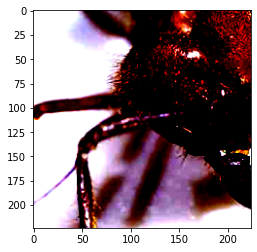

ants


In [58]:
test_img = Image.open(osp.join('.','data','hymenoptera_data','test','ant6.jpg'))
# test_img = Image.open(osp.join('.','data','hymenoptera_data','test','bee4.jpg'))
test_input = transform(test_img, phase="val")

img_show = test_input.numpy().transpose((1, 2, 0))
img_show = np.clip(img_show, 0, 1)
plt.imshow(img_show)
plt.show()
# print(test_input.size())
test_input = test_input.unsqueeze(0)
# print(test_input.size())
test_out = net(test_input)
_, test_pred = torch.max(test_out, 1)
gt = ["ants", "bees"]
print(gt[test_pred.numpy()[0]])